# Executive Summary

### **Objective:** Predict Apple stock 7 days in advance using a Recurrent Neural Network (RNN) regressor and Long Short-Term Memory (LSTM) architecture for optimization

#### **Reference**: 
- This is a Pytorch version of the original Keras LSTM Stock Predictor provided by [Super DataScience](https://www.superdatascience.com/deep-learning/)
- More details of LTSM can be found in [Wikipedia](https://en.wikipedia.org/wiki/Long_short-term_memory) 

#### **Critical Steps in the Analysis**:
- Load data (5 years/1251 trading days of historical price for Apple stock)
- Process data 
    - normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).
    - cut time series into sequence for sequential prediction with the most recent pricing information
    - Split training and testing set 4:1
- Build and run RNN regression model
    - layer 1 using LSTM module with 5 hidden units
    - layer 2 using fully connected module with one unit
    - loss function: mean_squared_error
- Check model performance and visualization

## Step 1: Loading the data

First let's load in our time series - a history of 1251 days of Apple's stock price. Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [ ]:
# download the data
!wget https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv

--2022-03-15 09:36:18--  https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29580549 (28M) [text/plain]
Saving to: ‘all_stocks_5yr.csv’

all_stocks_5yr.csv  100%[===================>]  28.21M   136MB/s    in 0.2s    

2022-03-15 09:36:20 (136 MB/s) - ‘all_stocks_5yr.csv’ saved [29580549/29580549]



In [ ]:
# check data loaded in directory
!ls .

all_stocks_5yr.csv  sample_data


In [ ]:
# download libraries for analysis and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Importing the training set for Apple stocks daily stock price for 5 years
dataset = data = pd.read_csv('./all_stocks_5yr.csv')
dataset_cl = dataset[dataset['Name']=='AAPL'].close.values

In [ ]:
# Feature Scaling 
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))

# scale the data
dataset_cl = dataset_cl.reshape(dataset_cl.shape[0], 1)
dataset_cl = sc.fit_transform(dataset_cl)

## Step 2:  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now let's window the input time series as described above!  

In [ ]:
#Create a function to process the data into 7 day look back slices
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)
X, y = processData(dataset_cl, 7)


## Step 3: Split training and testing sets

In order to perform proper testing on our dataset we will save the last 1/5 of it for validation (or testing).  

Note that we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 4/5 of it), and validate on a later chunk (the last 1/5) as this simulates how we would predict *future* values of a time series.

In [ ]:
X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

1000
251
1000
251


## Step 4:  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 64 features in hidden state (hidden_size),  and 3 recurrent layers (num_layers)
    - note that the expected input is 7 days of stock price (input_size = (window_size,1))
    - drop out 10% of the outputs of each RNN layer except last layer
    - introduce bidirectional RNN (feeding stock price in normal time order for one network and in reverse time order for another)
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used

In [ ]:
# Set up RNN regression models
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional+1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)
        
        return outs, hidden_state

In [ ]:
# Specify hyper-parameters

INPUT_SIZE = 7
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 128

learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE,bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [ ]:
# See model profile 
rnn

RNN(
  (rnn): LSTM(7, 64, num_layers=3, dropout=0.1)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
# Monitor MSE loss for each epoch and for every 20 epoch, switch off dropout for evaluation purposes 
history = []
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

# we use all the data in one batch
inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()

for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state) 
    # print(output.size())

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()                     # back propagation
    optimiser.step()                    # update the parameters
    
    if epoch % 20 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.1975467950105667, eval loss 0.7273387312889099
epoch 1, loss 0.1732746958732605
epoch 2, loss 0.1501857191324234
epoch 3, loss 0.12802191078662872
epoch 4, loss 0.10620840638875961
epoch 5, loss 0.0850948840379715
epoch 6, loss 0.06480320543050766
epoch 7, loss 0.04606378450989723
epoch 8, loss 0.03055032528936863
epoch 9, loss 0.022137030959129333
epoch 10, loss 0.026181379333138466
epoch 11, loss 0.03906293585896492
epoch 12, loss 0.04317311942577362
epoch 13, loss 0.03807911276817322
epoch 14, loss 0.02945636212825775
epoch 15, loss 0.02394001930952072
epoch 16, loss 0.021341027691960335
epoch 17, loss 0.02122589200735092
epoch 18, loss 0.0220780186355114
epoch 19, loss 0.02338247187435627
epoch 20, loss 0.02477165311574936, eval loss 0.23123624920845032
epoch 21, loss 0.025212297216057777
epoch 22, loss 0.025139035657048225
epoch 23, loss 0.024635758250951767
epoch 24, loss 0.023289456963539124
epoch 25, loss 0.02169725112617016
epoch 26, loss 0.01993623562157154
ep

In [ ]:
# display weights for the 64 hidden features after training 
rnn.out.weight 

Parameter containing:
tensor([[ 0.1109, -0.1144,  0.0994, -0.0532,  0.1257,  0.0243,  0.1003, -0.0284,
         -0.0035, -0.0259, -0.0148,  0.0517,  0.0296, -0.0952, -0.0326, -0.0199,
          0.0175,  0.0579,  0.0688, -0.1149, -0.0259,  0.1163, -0.0165,  0.1267,
         -0.0113, -0.0472,  0.0410, -0.1353, -0.0634,  0.1108,  0.0050,  0.1040,
         -0.0318,  0.0246, -0.0147,  0.0254,  0.1356,  0.0707, -0.0538, -0.0742,
          0.0410,  0.0571, -0.0118, -0.0216, -0.0418,  0.0980,  0.0140, -0.1105,
          0.0002,  0.0124, -0.0224,  0.0930, -0.0853, -0.0265, -0.1034,  0.1286,
         -0.0530,  0.1072, -0.1126, -0.0005, -0.0839, -0.0088,  0.0248,  0.1220]],
       device='cuda:0', requires_grad=True)

In [ ]:
# display parameters for all features in all layers
for param in rnn.parameters():
    print(param.data)

tensor([[ 0.0887,  0.0078,  0.0213,  ...,  0.0857, -0.0783, -0.0264],
        [-0.0544,  0.0908, -0.0359,  ..., -0.0066, -0.0358,  0.1190],
        [ 0.0031, -0.1426, -0.1291,  ...,  0.0411,  0.0166, -0.0425],
        ...,
        [-0.1180, -0.0539,  0.0840,  ...,  0.0840, -0.1042, -0.0950],
        [ 0.0491, -0.0526, -0.0817,  ...,  0.0957,  0.0086, -0.0840],
        [-0.0500,  0.1214,  0.0965,  ...,  0.0130, -0.0644,  0.1767]],
       device='cuda:0')
tensor([[ 0.1006,  0.0733, -0.0490,  ..., -0.0988, -0.0499, -0.0679],
        [ 0.0008,  0.0822,  0.0412,  ..., -0.0455,  0.0314,  0.0385],
        [-0.0527, -0.0784,  0.0957,  ...,  0.1324, -0.0794, -0.0010],
        ...,
        [-0.0704,  0.0526,  0.0473,  ..., -0.0795, -0.0160,  0.0981],
        [-0.0050,  0.1056, -0.0204,  ...,  0.0762, -0.0503,  0.0421],
        [-0.0957,  0.1214,  0.0697,  ...,  0.0295,  0.1312,  0.1064]],
       device='cuda:0')
tensor([ 0.0216, -0.0162,  0.0917,  0.0581,  0.0608,  0.0200, -0.0203,  0.0632,
    

## Step 5: Checking model performance

With our model fit we can now make predictions on both our training and testing sets.

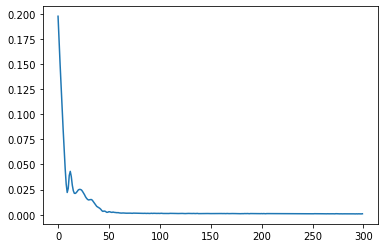

In [ ]:
# plot the history of losses in the 300 epoch training
plt.plot(history)

In [ ]:
# Snapshot of the test data 
X_test[0]

array([[0.53324732, 0.53097957, 0.5909131 , 0.5891313 , 0.59358582,
        0.60338576, 0.61342868]])

In [ ]:
# use model on test data
rnn.eval()

test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

In [ ]:
# see test data profile 
test_predict_cpu.shape

(251, 1, 1)

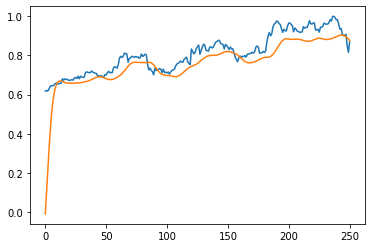

In [ ]:
# backtest prediction against actuals on test data
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))

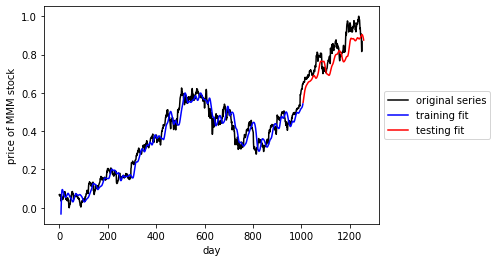

In [ ]:
# visualize backtesting of prediction against actuals on both training and testing datasets 
# plot original data
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of MMM stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
